In [1]:
# Instalação de dependências
!pip install datasets tensorflow scikit-learn pandas imbalanced-learn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets import load_dataset
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, LSTM, Dense, Dropout,
    Conv1D, GlobalMaxPooling1D, concatenate
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Hiperparâmetros
CONFIG = {
    'MAX_WORDS': 20000, 'MAX_LEN': 50, 'EMBEDDING_DIM': 128,
    'N_SPLITS': 5, 'BATCH_SIZE': 128, 'EPOCHS': 5,
    'TARGET_SAMPLES': 5000, 'TOXICITY_THRESHOLD': 0.5
}

LABEL_COLUMNS = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

In [2]:
def process_data(config, label_cols):
    print("Carregando dataset...")
    dataset = load_dataset("civil_comments", split='train').to_pandas()

    # Definição de rótulos
    dataset['non_toxic'] = (dataset[label_cols].sum(axis=1) == 0).astype(int)

    def get_label(row):
        for label in label_cols:
            if row[label] > config['TOXICITY_THRESHOLD']: return label
        return 'non_toxic'

    dataset['label'] = dataset.apply(get_label, axis=1)
    return dataset

def balance_data(df, target):
    dfs = []
    minority_data = []
    minority_labels = []

    # Undersampling
    for label in df['label'].unique():
        subset = df[df['label'] == label]
        if len(subset) >= target:
            dfs.append(subset.sample(n=target, random_state=42))
        else:
            minority_data.append(subset)
            minority_labels.append(label)

    # Oversampling
    if minority_data:
        full_minority = pd.concat(minority_data)
        ros = RandomOverSampler(sampling_strategy={l: target for l in minority_labels}, random_state=42)
        X_res, y_res = ros.fit_resample(full_minority[['text']], full_minority['label'])
        dfs.append(pd.DataFrame({'text': X_res['text'], 'label': y_res}))

    return pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

df_raw = process_data(CONFIG, LABEL_COLUMNS)
df_final = balance_data(df_raw, CONFIG['TARGET_SAMPLES'])

print(f"Dataset final: {len(df_final)} amostras.")
print(df_final['label'].value_counts())

Carregando dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset final: 35000 amostras.
label
insult             5000
toxicity           5000
identity_attack    5000
sexual_explicit    5000
non_toxic          5000
threat             5000
obscene            5000
Name: count, dtype: int64


In [3]:
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(df_final['label']))

tokenizer = Tokenizer(num_words=CONFIG['MAX_WORDS'])
tokenizer.fit_on_texts(df_final['text'])
X_padded = pad_sequences(tokenizer.texts_to_sequences(df_final['text']), maxlen=CONFIG['MAX_LEN'])

In [4]:
def build_model(cfg, n_classes):
    inp = Input(shape=(cfg['MAX_LEN'],))
    emb = Embedding(cfg['MAX_WORDS'], cfg['EMBEDDING_DIM'])(inp)

    # LSTM Branch
    lstm = Bidirectional(LSTM(32, return_sequences=False))(emb)

    # CNN Branch
    cnns = [GlobalMaxPooling1D()(Conv1D(32, k, activation='relu')(emb)) for k in [2, 3, 4]]
    cnn = concatenate(cnns)

    # Merge
    x = concatenate([lstm, cnn])
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

build_model(CONFIG, len(le.classes_)).summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 49, 32)    │      8,224 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 48, 32)    │     12,320 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 47, 32)    │     16,416 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     41,216 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 160)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 160)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     10,304 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │        455 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,648,935 (10.10 MB)

 Trainable params: 2,648,935 (10.10 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
skf = StratifiedKFold(n_splits=CONFIG['N_SPLITS'], shuffle=True, random_state=42)
class_weights = dict(enumerate(class_weight.compute_class_weight(
    'balanced', classes=np.unique(le.transform(df_final['label'])), y=le.transform(df_final['label']))))

histories, f1_scores, acc_scores = [], [], []

# Listas para armazenar todos os rótulos verdadeiros e preditos de todas as folds
all_y_true = []
all_y_pred = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_padded, np.argmax(y_encoded, axis=1)), 1):
    print(f"\nFold {fold}/{CONFIG['N_SPLITS']}")

    model = build_model(CONFIG, len(le.classes_))
    history = model.fit(
        X_padded[train_idx], y_encoded[train_idx],
        validation_data=(X_padded[val_idx], y_encoded[val_idx]),
        epochs=CONFIG['EPOCHS'], batch_size=CONFIG['BATCH_SIZE'],
        callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
        class_weight=class_weights, verbose=1
    )

    histories.append(history)
    y_pred = np.argmax(model.predict(X_padded[val_idx]), axis=1)
    y_true = np.argmax(y_encoded[val_idx], axis=1)

    # Armazenar rótulos verdadeiros e preditos para avaliação geral
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

    f1_scores.append(f1_score(y_true, y_pred, average='macro'))
    acc_scores.append(np.mean(y_pred == y_true))
    print(f"Fold {fold} F1: {f1_scores[-1]:.4f}")


Fold 1/5
Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.3724 - loss: 1.5895 - val_accuracy: 0.7666 - val_loss: 0.5193
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8237 - loss: 0.4566 - val_accuracy: 0.8780 - val_loss: 0.3415
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9265 - loss: 0.2193 - val_accuracy: 0.9017 - val_loss: 0.2952
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9650 - loss: 0.1104 - val_accuracy: 0.8856 - val_loss: 0.3496
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9821 - loss: 0.0622 - val_accuracy: 0.8990 - val_loss: 0.3707
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 1 F1: 0.8995

Fold 2/5
Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3785 - loss: 1.5913 - val_accuracy: 0.7926 - val_loss: 0.4948
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8313 - loss: 0.4509 - val_accuracy: 0.8814 - val_loss: 0.3112
Epoch 3/5
219/219 ━━━━━━


--- Avaliação Geral da Cross-Validation ---
Acurácia Geral: 0.9033
F1-Score Geral (Macro): 0.9012
Recall Geral (Macro): 0.9033

Relatório de Classificação Detalhado:
                 precision    recall  f1-score   support

identity_attack       0.95      1.00      0.98      5000
         insult       0.82      0.87      0.85      5000
      non_toxic       0.81      0.79      0.80      5000
        obscene       0.99      1.00      1.00      5000
sexual_explicit       0.98      1.00      0.99      5000
         threat       0.99      1.00      1.00      5000
       toxicity       0.76      0.67      0.71      5000

       accuracy                           0.90     35000
      macro avg       0.90      0.90      0.90     35000
   weighted avg       0.90      0.90      0.90     35000



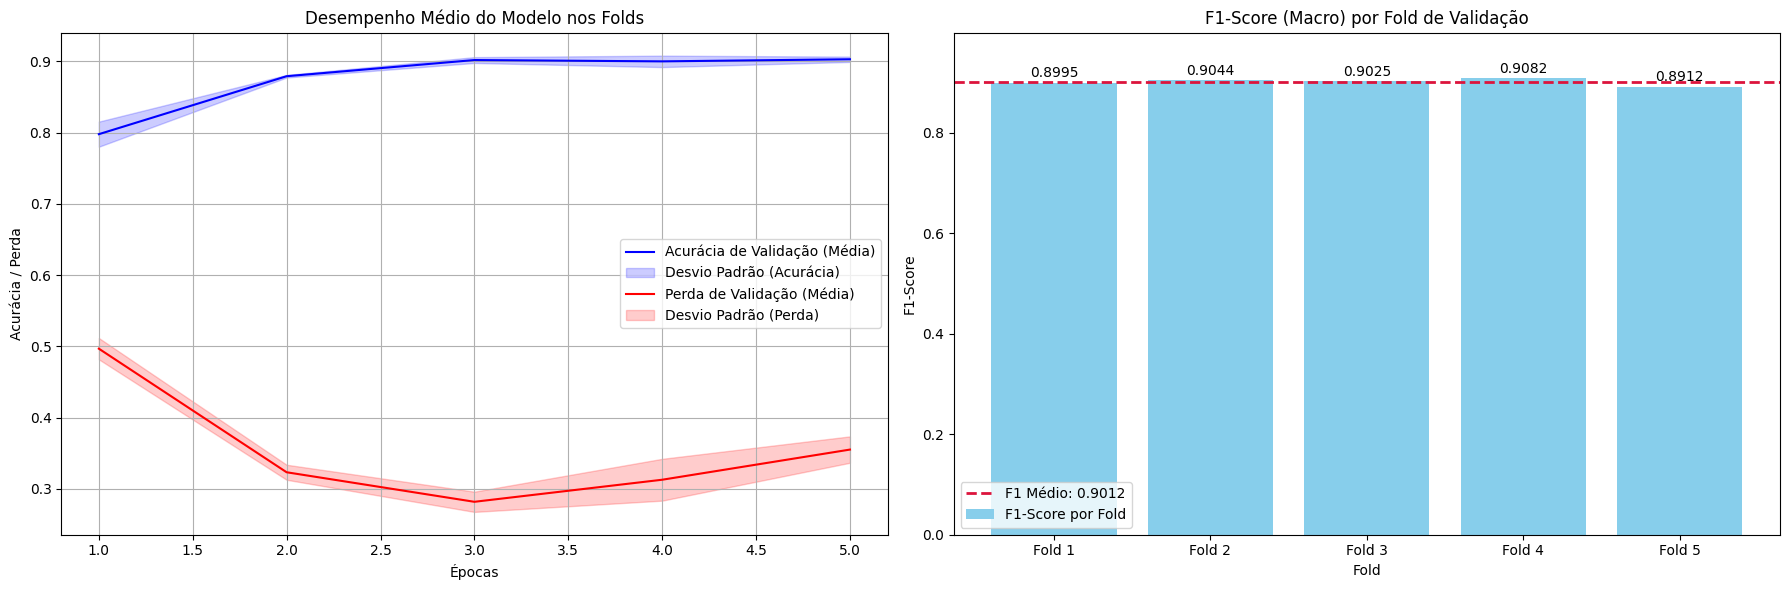

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, f1_score, recall_score, accuracy_score

def plot_cv_history(histories, f1_scores):
    max_epochs = max([len(h.history['val_loss']) for h in histories])

    val_accs = []
    val_losses = []
    for h in histories:
        acc = h.history['val_accuracy']
        loss = h.history['val_loss']
        acc_padded = np.pad(acc, (0, max_epochs - len(acc)), 'edge')
        loss_padded = np.pad(loss, (0, max_epochs - len(loss)), 'edge')
        val_accs.append(acc_padded)
        val_losses.append(loss_padded)

    val_accs = np.array(val_accs)
    val_losses = np.array(val_losses)

    acc_mean = np.mean(val_accs, axis=0)
    acc_std = np.std(val_accs, axis=0)
    loss_mean = np.mean(val_losses, axis=0)
    loss_std = np.std(val_losses, axis=0)
    epochs = range(1, max_epochs + 1)

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc_mean, 'b-', label='Acurácia de Validação (Média)')
    plt.fill_between(epochs, acc_mean - acc_std, acc_mean + acc_std, color='blue', alpha=0.2, label='Desvio Padrão (Acurácia)')
    plt.plot(epochs, loss_mean, 'r-', label='Perda de Validação (Média)')
    plt.fill_between(epochs, loss_mean - loss_std, loss_mean + loss_std, color='red', alpha=0.2, label='Desvio Padrão (Perda)')
    plt.title('Desempenho Médio do Modelo nos Folds')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia / Perda')
    plt.legend(loc='best')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    fold_labels = [f'Fold {i+1}' for i in range(len(f1_scores))]
    f1_mean = np.mean(f1_scores)
    bars = plt.bar(fold_labels, f1_scores, color='skyblue', label='F1-Score por Fold')
    plt.axhline(f1_mean, color='crimson', linestyle='--', linewidth=2, label=f'F1 Médio: {f1_mean:.4f}')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom')
    plt.title('F1-Score (Macro) por Fold de Validação')
    plt.xlabel('Fold')
    plt.ylabel('F1-Score')
    plt.ylim(top=max(f1_scores) * 1.1)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

print("\n--- Avaliação Geral da Cross-Validation ---")
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

overall_f1_macro = f1_score(all_y_true, all_y_pred, average='macro')
overall_recall_macro = recall_score(all_y_true, all_y_pred, average='macro')
overall_accuracy = accuracy_score(all_y_true, all_y_pred)

print(f"Acurácia Geral: {overall_accuracy:.4f}")
print(f"F1-Score Geral (Macro): {overall_f1_macro:.4f}")
print(f"Recall Geral (Macro): {overall_recall_macro:.4f}")

print("\nRelatório de Classificação Detalhado:")
print(classification_report(all_y_true, all_y_pred, target_names=le.classes_))

plot_cv_history(histories, f1_scores)